In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from statsmodels.stats import multitest
from matplotlib.backends.backend_pdf import PdfPages
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

from Modules import plot_ax_violin
from Modules import read_data
from Modules import sholl_analysis

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams["xtick.major.size"] = 2
plt.rcParams["ytick.major.size"] = 2
plt.rcParams['xtick.major.width'] = .5
plt.rcParams['ytick.major.width'] = .5

In [8]:
def read_lin_data():
    kwargs = {'sep':'\t', 'header':0, 'index_col':0}
    fname = 'Datasets/Lab_Pvalb-tpm.tsv'
    df = pd.read_csv(fname, **kwargs)
    
    fname = 'Datasets/Lab_Pvalb-transcriptional_labels.tsv'
    df_labels = pd.read_csv(fname, **kwargs)
    df_labels = df_labels.loc[df_labels.index.isin(df.columns)]
    df_labels.sort_values('Age', inplace=True)
    df = np.log2(1+df.loc[:,df_labels.index])
    
    fname = 'Datasets/Lab_Pvalb-Age-Predictions_2.tsv'
    df_predict = pd.read_csv(fname, **kwargs)
    df_predict = df_predict.loc[df_labels.index,:].iloc[:,1:].copy()
    
    return df, df_labels, df_predict

def get_family_data(df, family):
    fname = '/home/soma/Documents/Newest/analysisfiles/%smouse.txt' % family
    with open(fname) as f:
        genes = [line.split()[0] for line in f]
    
    df = df.loc[df.index.isin(genes)]
    
    return df

def get_ion_data():
    df_lin, df_labels, df_predict = read_lin_data()
    is_bc = df_labels['Morph-PV-types'] == 'vBC'
    df= df_lin.loc[:,is_bc].copy()
    df.columns = df_labels.Age[is_bc]
    df = df.loc[(df.values>1).sum(axis=1)>5].copy()
    columns = np.array(['<P21'] * df.shape[1])
    columns[df.columns>21] = '>P21'
    arrays = (columns, df.columns)
    df.columns = pd.MultiIndex.from_arrays(arrays, names=('Category', 'Age'))
        
    df_volt = get_family_data(df, 'VOLTAGEGATED')
    df_lig = get_family_data(df, 'LIGANDGATED')
    
    return df_volt, df_lig

def get_ephys_data(ephys_types = ['AP peak amplitude (mV)', 'AP halfwidth (ms)', 'Attenuation'],
                 ephys_names = ['AP amplitude (mV)', 'AP halfwidth (ms)', 'Attenuation']
                ):
    # keep only vBC cells
    df_ephys = plot_ax_violin.read_ephys_data('Lab_Pvalb')
    df_ephys.index = df_ephys.index.get_level_values(0)
    df_ephys.index.name = 'Cell'
    df_labels = read_data.read_dataset_labels('Lab_Pvalb')
    df_labels = df_labels.loc[df_labels.index.isin(df_ephys.index)]
    df_labels = df_labels.loc[df_labels.CellType == 'vBC'].sort_values('Age')
    df_ephys = df_ephys.loc[df_labels.index, ephys_types].copy()
    df_ephys.index = df_labels.Age
    df_ephys.columns = ephys_names
    
    return df_ephys

def get_ion_signif(df_ion):
    df_young = df_ion.xs('<P21', level='Category', axis=1)
    df_old = df_ion.xs('>P21', level='Category', axis=1)
    df_stat = pd.DataFrame(np.NaN, index=df_ion.index, columns=['Score', 'Pval'])
    for gene in df_stat.index:
        df_stat.loc[gene] = mannwhitneyu(df_young.loc[gene], df_old.loc[gene], alternative='two-sided')
    df_stat.Pval = df_stat.Pval
    df_stat.sort_values('Pval', inplace=True)
    df_stat['Padj'] = multitest.multipletests(df_stat.Pval.values, method='fdr_bh')[1]
    
    arrays = [['<P21'], ['>P21']]
    names = ('Category_1', 'Category_2')
    index = pd.MultiIndex.from_arrays(arrays, names=names)
    df_fdr = pd.DataFrame(np.NaN, index=index, columns=df_stat.index)
    df_fdr.iloc[0,:] = df_stat.Padj.values

    return df_stat, df_fdr

def create_family_plot(dfs, names, fig, axbg, top=0.90):
    df_merge = pd.concat(dfs, axis=0)
    df_stat, df_fdr = get_ion_signif(df_merge)

    fig.suptitle('Figure S8', fontsize=14, y=.93)
    
    celltypes = ('<P21', '>P21')
    df_marker = pd.read_csv('References/marker_ref.txt', sep='\t', header=0, index_col=0)
    kwargs = {'left':.10,
              'right':.9,
              'row_count':10,
              'rotation':45,
              'ticklabels':celltypes,
              'df_marker':df_marker,
              'show_violin':False, 
              'show_error':True,
              'show_box':False,
              'height':.040,
              'dh':.016,
              'labelsize':6,
              'ticksize':5,
              'dw':.03,
              'ylabel_coords':(-0.33, 0.5),
              'ticklabel_loc':'BOTTOM',
              'show_signif':True,
              'fdr_min':0.1
             }
    
    letters = 'BC'
    
    for df, name, letter in zip(dfs, names, letters):
        df_key = df_stat.loc[df_stat.index.isin(df.index)]
        df_violin = df.loc[df_key.index].T
        df_violin.index = df_violin.index.get_level_values('Category')
        df_padj = df_fdr.loc[:,df_violin.columns]
        
        fig.text(.1, top, letter, fontsize=14, ha='left', va='top')
        fig.text(.5, top, name, fontsize=12, ha='center', va='top')
        kwargs['show_signif'] = df_padj
        args = (fig, top-.025, df_violin, celltypes)
        top = plot_ax_violin.plot_generated_electrophys(*args, **kwargs)
        top = top - .03
    
    return

def plot_ephys_by_age(df_ephys, fig, top=0.90):
    xvals = df_ephys.index.values
    width = .187
    height = width / 11 * 8.5 * 0.7
    
    fig.text(.1, top+.01, 'A', fontsize=14, ha='left', va='top')
    
    color_dict = sholl_analysis.get_age_color_converter()
    colors = df_ephys.index.map(color_dict)
    
    for col, val in enumerate(df_ephys.columns):
        ax = fig.add_axes([.16 + 0.25*col, top-height, width, height])
        ax.tick_params(size=1, labelsize=6)
        ax.set_xlabel('Age (days)', fontsize=7)
        ax.set_ylabel(val, fontsize=7)
        
        yvals = df_ephys[val].values
        
        xshift = xvals + (np.random.rand(xvals.size)-.5) * 1
        yshift = yvals + (np.random.rand(yvals.size)-.5) * yvals.max() / 50
        approx = lowess(yshift, xshift, frac=.66, is_sorted=False, return_sorted=True)
    
        ax.scatter(xvals, yvals, facecolor=colors, edgecolor='k', linewidth=.25, s=16)
        ax.plot(approx[:,0], approx[:,1], color='black')
        
        ylow, yhigh = yvals.min(), yvals.max()
        xlow, xhigh = xvals.min()-1, xvals.max()+1
        ydiff = (yhigh-ylow)*.02
        ylow = ylow-ydiff
        yhigh = yhigh+ydiff
        ax.axis([xlow,xhigh,ylow,yhigh])
        
        ax.plot([21,21], [ylow,yhigh], linewidth=1, color='gray', linestyle='dashed')
    
    ax = fig.add_axes([.89, top-height, 0.01, height])
    sholl_analysis.plot_age_scale(xvals, ax, orientation='vertical')
        
    return

In [3]:
%%time

df_volt, df_lig = get_ion_data()
df_ephys = get_ephys_data()

CPU times: user 875 ms, sys: 48.2 ms, total: 923 ms
Wall time: 966 ms


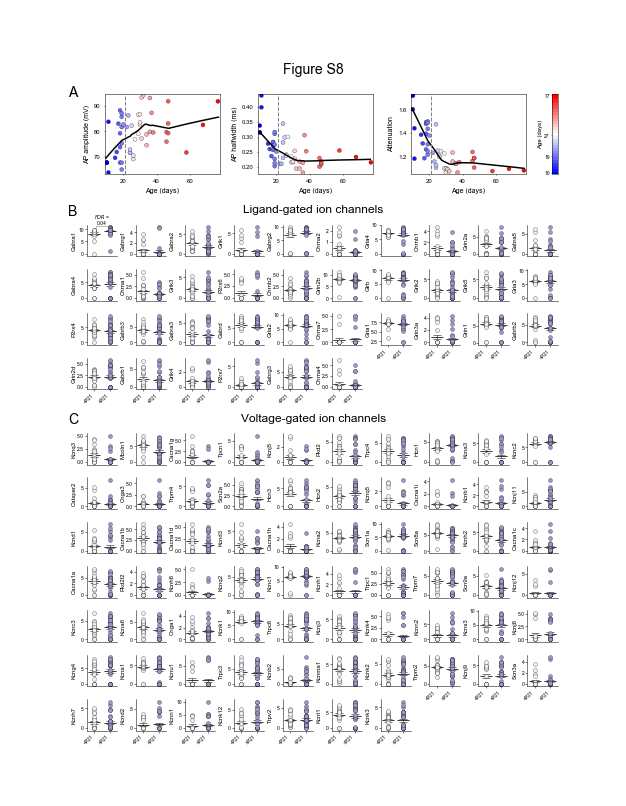

CPU times: user 15.8 s, sys: 3.06 s, total: 18.8 s
Wall time: 12.3 s


In [9]:
%%time

fig = plt.figure(figsize=(8.5,11))
axbg = fig.add_axes([0,0,1,1], frame_on=False)
axbg.set_xticks([]), axbg.set_yticks([]), axbg.axis([0,1,0,1])
dfs = [df_lig, df_volt]
names = ['Ligand-gated ion channels', 'Voltage-gated ion channels']
plot_ephys_by_age(df_ephys, fig, top=0.89)
create_family_plot(dfs, names, fig, axbg, top=0.75)

fig.savefig('Figures/Figure S8.pdf')
plt.show()
plt.close()